In [1]:
import numpy as np
import pickle
import tensorflow as tf
import random
from Vel2Img import *
import os
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#load the data set
with open('./data/velocity64.pickle', 'rb') as handle:
    velocities = pickle.load(handle)
#normalize the images between -1 and 1
for i in range(velocities.shape[0]):
    velocities[i,:,:,:]=2*(velocities[i,:,:,:]-velocities[i,:,:,:].min())/(velocities[i,:,:,:].max()-velocities[i,:,:,:].min())-1

In [3]:
#load the low resolution set
with open('./data/velocity8.pickle', 'rb') as handle:
    velocities8 = pickle.load(handle)
#normalize the images between -1 and 1
for i in range(velocities8.shape[0]):
    velocities8[i,:,:,:]=2*(velocities8[i,:,:,:]-velocities8[i,:,:,:].min())/(velocities8[i,:,:,:].max()-velocities8[i,:,:,:].min())-1

In [4]:
inputImage=np.zeros([10,64,64,3])
for i in range(10):
    inputImage[i,:,:,:]=scipy.misc.toimage( np.reshape(velocityFieldToPng(velocities[i,:,:,:]), [64, 64, 3]) , cmin=0.0, cmax=1.0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


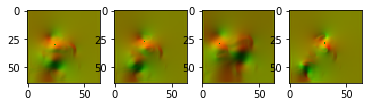

In [5]:
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4)
ax1.imshow(inputImage[0,:,:,:])
ax2.imshow(inputImage[1,:,:,:])
ax3.imshow(inputImage[2,:,:,:])
ax4.imshow(inputImage[3,:,:,:])

plt.show()

In [6]:
inputImage8=np.zeros([10,8,8,3])
for i in range(10):
    inputImage8[i,:,:,:]=scipy.misc.toimage( np.reshape(velocityFieldToPng(velocities8[i,:,:,:]), [8, 8, 3]) , cmin=0.0, cmax=1.0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


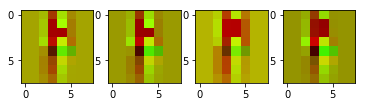

In [7]:
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4)
ax1.imshow(inputImage8[0,:,:,:])
ax2.imshow(inputImage8[1,:,:,:])
ax3.imshow(inputImage8[2,:,:,:])
ax4.imshow(inputImage8[3,:,:,:])
#f.title("Low Res Input 8x8")
plt.show()

In [8]:
#Build the discriminator

def convolution2d(input, biases, weights, strides, padding_kind='SAME'):
    input = tf.nn.conv2d(input, weights, [1,strides,strides,1], padding=padding_kind)
    input = tf.nn.bias_add(input, biases)
    input = tf.nn.leaky_relu(input)
    return input

def discriminator(x_image):
    
    x_image=x_image+tf.random_normal(shape=tf.shape(x_image),mean=0.0, stddev=0.1, dtype=tf.float32)
    #layer1: Convolution
    weights1=tf.Variable(tf.random_normal([12,12,2,2], stddev=0.01),name='d_Wconv1')
    #[filter_height, filter_width, in_channels, out_channels]
    #bias=out_channels
    bias1=tf.Variable(tf.random_normal([2],stddev=0.01), name='d_Bconv1')
    stride1=2
    out1=convolution2d(x_image,bias1,weights1,stride1)
    #print(out1.shape)
    #layer2: Convolution
    weights2=tf.Variable(tf.random_normal([6,6,2,4], stddev=0.01),name='d_Wconv2')
    bias2=tf.Variable(tf.random_normal([4], stddev=0.01),name='d_Bconv2')
    stride2=4
    out2=convolution2d(out1,bias2,weights2,stride2)
    #print(out2.shape)
    #layer3: Convolution
    weights3=tf.Variable(tf.random_normal([4,4,4,8],stddev=0.01), name='d_Wconv3')
    bias3=tf.Variable(tf.random_normal([8],stddev=0.01), name='d_Bconv3')
    stride3=2
    out3=convolution2d(out2,bias3,weights3,stride3)
    #print(out3.shape)
    #layer4: Convolution
    weights4=tf.Variable(tf.random_normal([3,3,8,16], stddev=0.01),name='d_Wconv4')#weights==filters
    bias4=tf.Variable(tf.random_normal([16], stddev=0.01),name='d_Bconv4')
    stride4=2
    out4=convolution2d(out3,bias4,weights4,stride4)
    #print(out4.shape)
    #layer5: Fully Connected Layer
    out4 = tf.reshape(out4, shape=[-1, 64 ]) # flatten
    fc_1weights = tf.Variable(tf.random_normal([64, 1],stddev=0.01), name='d_WFCN1')
    fc_1bias   = tf.Variable(tf.random_normal([1], stddev=0.01),name='d_BFCN1')
    fc1 = tf.add(tf.matmul(out4, fc_1weights), fc_1bias)
    fc1 = tf.nn.sigmoid(fc1)
    
    return fc1

In [9]:
#Build the Generator

def deconvolution2d(input, weights, biases,outputShape, strides, padding_kind='SAME',activation='leaky'):
    # needed for dynamic shape with deconvolution
    deconvShape = tf.stack([tf.shape(input)[0], strides*tf.shape(input)[1], strides*tf.shape(input)[2], tf.shape(input)[3]])
    input = tf.image.resize_images(images=input,
    size=tf.stack([strides*tf.shape(input)[1], strides*tf.shape(input)[2]]),
    method=tf.image.ResizeMethod.BILINEAR
        )
    #input=tf.nn.max_pool_with_argmax(input, ksize=[1, strides, strides, 1], strides=[1, strides, strides, 1], padding=padding_kind)
    input=convolution2d(input,biases,weights,1)
    return input

def generator(noise):
    
    #layer1: DeConvolution
    weights5=tf.Variable(tf.random_normal([6,6,2,256],stddev=0.1), name='g_Wdeconv1')#weights==filters
    #[filter_height, filter_width, in_channels, out_channels]
    #bias=out_channels
    bias5=tf.Variable(tf.random_normal([256], stddev=0.1),name='g_Bdeconv1')
    stride5=2#facror of upscale
    deconv1=deconvolution2d(noise,weights5,bias5,[None, 16,16, 256],stride5)
    #print("deconv1",deconv1.shape)
    deconv1=tf.nn.dropout(deconv1,0.50)
    #layer2: DeConvolution
    weights6=tf.Variable(tf.random_normal([6,6,256,128], stddev=0.1),name='g_Wdeconv2')#weights==filters
    bias6=tf.Variable(tf.random_normal([128],stddev=0.1), name='g_Bdeconv2')
    stride6=1
    deconv2=deconvolution2d(deconv1,weights6,bias6,[None, 16,16, 128],stride6)
    
    #layer3: DeConvolution
    weights7=tf.Variable(tf.random_normal([6,6,128,64], stddev=0.1), name='g_Wdeconv3')#weights==filters
    bias7=tf.Variable(tf.random_normal([64], stddev=0.1), name='g_Bdeconv3')
    stride7=1
    deconv3=deconvolution2d(deconv2,weights7,bias7,[None, 16,16, 64],stride7)
    #deconv3=tf.nn.dropout(deconv3,0.50)
    #layer4: DeConvolution
    weights9=tf.Variable(tf.random_normal([6,6,64,32], stddev=0.1),name='g_Wdeconv4')#weights==filters
    bias9=tf.Variable(tf.random_normal([32],stddev=0.1), name='g_Bdeconv4')
    stride9=2
    deconv4=deconvolution2d(deconv3,weights9,bias9,[None, 32,32, 32],stride9)
    
    #layer5: DeConvolution
    weights8=tf.Variable(tf.random_normal([1,1,32,2], stddev=0.1),name='g_Wdeconv5')#weights==filters
    bias8=tf.Variable(tf.random_normal([2], stddev=0.1), name='g_Bdeconv5')
    stride8=2
    xOut=deconvolution2d(deconv4,weights8,bias8,[None, 64,64, 2],stride8,activation='tanh')
    
    return xOut



In [10]:
#Training
sess = tf.Session()
ImageInput = tf.placeholder(tf.float32,shape = [None, 64,64, 2])
NoiseInput = tf.placeholder(tf.float32,shape=[None, 8,8, 2])
epNo= tf.placeholder(tf.float32)

In [11]:
GeneratedImage = generator(NoiseInput) #GeneratedImage holds the generated images

RealImages = discriminator(ImageInput) #holds discriminator outputs (unnormalized) for the real images
FakeImages = discriminator(GeneratedImage) #will hold the discriminator output (unnormalized) for generated images

In [12]:
# Build Loss
Generator_L2Loss= tf.losses.mean_squared_error(labels=ImageInput,predictions=GeneratedImage)
Generator_L2LossMetric=tf.reduce_mean(Generator_L2Loss)
#Generator_loss = -tf.reduce_mean(tf.log(1.-FakeImages))# the loss function to optimize G is min (log 1-D), but in practice folks practically use max log D
Generator_loss  =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=FakeImages, labels=tf.ones_like(FakeImages)))
#Discriminator_loss= -tf.reduce_mean(tf.log(RealImages) + tf.log(1. - FakeImages))
#gen_l2_loss = tf.nn.l2_loss(y - gen_part)
gen_l1_loss = tf.reduce_mean(tf.abs(ImageInput- GeneratedImage))
Generator_loss =Generator_loss +gen_l1_loss#+Generator_L2LossMetric

In [13]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=RealImages, labels=tf.ones_like(RealImages)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=FakeImages , labels=tf.zeros_like(FakeImages )))
Discriminator_loss = d_loss_real + d_loss_fake

#Discriminator_loss=tf.reduce_sum(tf.square(d_out_real-1) + tf.square(Fake))/2

In [14]:
# separate each network variables
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [15]:
learning_rate=1e-3
# Create the Optimiser
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_genL2 = tf.train.AdamOptimizer(learning_rate=learning_rate*0.1)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate*0.1)
# Create training operations on the repective netork variable only
train_gen = optimizer_gen.minimize(Generator_loss, var_list=g_vars)
train_genL2 = optimizer_genL2.minimize(Generator_L2Loss, var_list=g_vars)
train_disc = optimizer_disc.minimize(Discriminator_loss, var_list=d_vars)

In [16]:
trainingEpochs=10000
preGANtrainingEpochs=0.1*trainingEpochs
batchSize= 1000
saveFreq=1000
loadNum = len(velocities)
#creating Seesion starting training
print("Starting training...")
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
g_loss_plot=[]
d_loss_plot=[]
# lets train for all epochs
for epoch in range(1,trainingEpochs+1):
    batch = []
    noise = []
    for currNo in range(0, batchSize):
        r = random.randint(0, loadNum-1)
        batch.append( velocities[r] )
        noise.append( velocities8[r] )
        
    # Generate noise to feed to the generator
    z = noise
    
    if epoch<preGANtrainingEpochs:
        # Train L2
        fed_dict={ImageInput: batch, NoiseInput: z}
        _, gl=sess.run([train_genL2,Generator_L2LossMetric],feed_dict=fed_dict)
        if epoch % 100 == 0 or epoch == 1:
            print('Epoch %i: Generator Loss: %f' % (epoch, gl))
    else:
        # Train Adversierial
        fed_dict = {ImageInput: batch, NoiseInput: z,epNo:epoch}
        t,_, _, gl, dl = sess.run([GeneratedImage,train_gen, train_disc, Generator_loss, Discriminator_loss],
                                    feed_dict=fed_dict)

        if epoch % saveFreq == 0 or epoch == 1:
            print('Epoch %i: Generator Loss: %f, Discriminator Loss: %f' % (epoch, gl, dl))
            g_loss_plot.append(gl)
            d_loss_plot.append(dl)
            outDir = "./Progress/"
            if not os.path.exists(outDir): 
                os.makedirs(outDir)   
            r = random.randint(0, batchSize-1)
            #scipy.misc.toimage(np.reshape(z[r,:,:,:],(8,8)) , cmin=0.0, cmax=1.0).save("%s/noise_%d.png" % (outDir,epoch))
           # g = sess.run([GeneratedImage], feed_dict={NoiseInput:z[r:r+1,:,:,:] })
            g = np.reshape(t[r], newshape=( 64, 64, 2))
            generatedImage=velocityFieldToPng(g)

            scipy.misc.toimage( np.reshape(generatedImage, [64, 64, 3]) , cmin=0.0, cmax=1.0).save(outDir+'/genImg_'+str(epoch).zfill(len(str(trainingEpochs))) +'.png')

print("Done...")


Starting training...
Epoch 1: Generator Loss: 168.368759
Epoch 100: Generator Loss: 2.676920
Epoch 200: Generator Loss: 1.258800
Epoch 300: Generator Loss: 0.769113
Epoch 400: Generator Loss: 0.556538
Epoch 500: Generator Loss: 0.434057
Epoch 600: Generator Loss: 0.361810
Epoch 700: Generator Loss: 0.306034
Epoch 800: Generator Loss: 0.268085
Epoch 900: Generator Loss: 0.225732
Epoch 1000: Generator Loss: 0.813329, Discriminator Loss: 1.449252


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


Epoch 2000: Generator Loss: 0.822601, Discriminator Loss: 1.006495
Epoch 3000: Generator Loss: 0.779049, Discriminator Loss: 1.006439
Epoch 4000: Generator Loss: 0.760150, Discriminator Loss: 1.006418
Epoch 5000: Generator Loss: 0.749809, Discriminator Loss: 1.006413
Epoch 6000: Generator Loss: 0.743210, Discriminator Loss: 1.006412
Epoch 7000: Generator Loss: 0.737346, Discriminator Loss: 1.006410
Epoch 8000: Generator Loss: 0.731541, Discriminator Loss: 1.006410
Epoch 9000: Generator Loss: 0.730798, Discriminator Loss: 1.006409
Epoch 10000: Generator Loss: 0.731070, Discriminator Loss: 1.006409
Done...


In [17]:
###Counting the learnable parameters
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    #print(variable_parameters)
    total_parameters += variable_parameters
print("Total No. Learnable Parameters for the GAN:",total_parameters)


Total No. Learnable Parameters for the GAN: 1572512


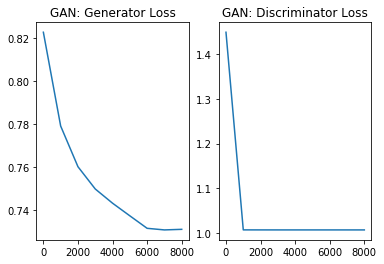

In [18]:
plt.subplot(121)
plt.plot(np.arange(0,trainingEpochs-preGANtrainingEpochs,saveFreq), np.array(g_loss_plot)[1:])
plt.title('GAN: Generator Loss')

plt.subplot(122)
plt.plot(np.arange(0,trainingEpochs-preGANtrainingEpochs,saveFreq), np.array(d_loss_plot)[:-1])
plt.title('GAN: Discriminator Loss')
plt.show()
#plt.savefig('./Result/losses.svg')
#plt.savefig('losses.png',bbox_inches='tight')

In [21]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./Model/model.ckpt")
print("Model saved in path: %s" % save_path)


Model saved in path: ./Model/model.ckpt


In [22]:
noResults=10
outDir = "./Result/"
if not os.path.exists(outDir): 
    os.makedirs(outDir) 

for i in range(noResults):
    r = random.randint(0, velocities8.shape[0])

    gI = sess.run([GeneratedImage], feed_dict={NoiseInput:velocities8[r:r+1,:,:,:] })

    g = np.reshape(gI, newshape=( 64, 64, 2))
    generatedImage=velocityFieldToPng(g)
    noiseInput=velocityFieldToPng(velocities8[r,:,:,:])

    scipy.misc.toimage( np.reshape(generatedImage, [64, 64, 3]) , cmin=0.0, cmax=1.0).save(outDir+'/genImg_'+str(i).zfill(len(str(noResults))) +'.png')
    scipy.misc.toimage( np.reshape(noiseInput, [8, 8, 3]) , cmin=0.0, cmax=1.0).save(outDir+'/noise_'+str(i).zfill(len(str(noResults))) +'.png')

print("Saved Results..")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  app.launch_new_instance()


Saved Results..
